# "When is the best time to consume coffee in order to stay maximally awake throughout your working hours?"
This is code to supplement the (not serious) poster available here: https://github.com/hubarruby/optimalcaffeine

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Define and plot my wakefulness throughout the day
(very subjective and not necessarily accurate)

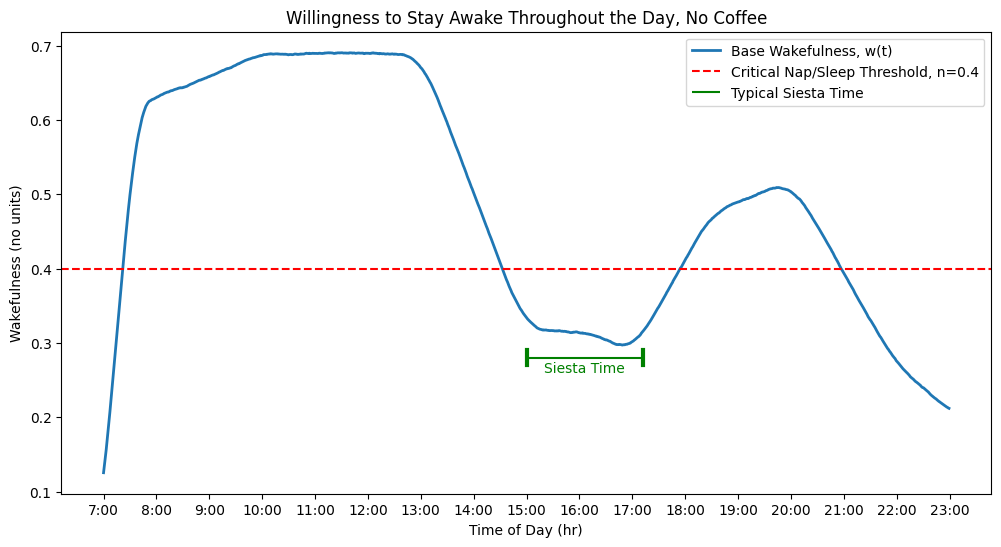

In [2]:
def moving_average(data, window_size):
    if window_size % 2 == 0:
        window_size += 1  # Ensure window size is odd
    pad_width = window_size // 2
    padded_data = np.pad(data, pad_width, mode='edge')  # Pad with edge values
    window = np.ones(window_size) / window_size
    smoothed_data = np.convolve(padded_data, window, mode='valid')
    return smoothed_data

x = np.asarray(range(1600))
y1 = np.zeros(len(x))

# Define each segment of wakefulness plot with continuous transitions
y1[:50] = 0.6125 * x[:50] / 50
y1[50:300] = 0.6125 + (1/2) * (1/1600) * (x[50:300] - 50)
y1[300:600] = y1[299]
y1[600:800] = y1[599] - 3 * (1/1600) * (x[600:800] - 600)
y1[800:900] = y1[799]
y1[900:1000] = y1[899] - (1/2) * (1/1600) * (x[900:1000] - 900)
y1[1000:1150] = y1[999] + 2 * (1/1600) * (x[1000:1150] - 1000)
y1[1150:1300] = y1[1149] + (1/2) * (1/1600) * (x[1150:1300] - 1150)
y1[1300:1500] = y1[1299] - 2 * (1/1600) * (x[1300:1500] - 1300)
y1[1500:1600] = y1[1499] - (1/1600) * (x[1500:1600] - 1500)
np.random.seed(0)
y1 = y1 + np.random.normal(0, 0.01, len(y1)) #add random noise

# Applying a moving average to smooth the function
y_smooth = moving_average(y1, 75)

plt.figure(figsize=(12, 6))
plt.plot(x, y_smooth, linewidth=2, label='Base Wakefulness, w(t)')
plt.title("Willingness to Stay Awake Throughout the Day, No Coffee")

tick_positions = np.arange(0, 1601, 100)  # Positions every 100 units
tick_labels = [(7 + i) % 24 for i in range(0, len(tick_positions))]  # Calculating hours from 7 AM to 11 PM
tick_labels = [f'{label}:00' for label in tick_labels]  # Formatting as 'hour:00'
plt.xticks(tick_positions, tick_labels)

plt.axhline(y=0.4, color='red', linestyle='--', label='Critical Nap/Sleep Threshold, n=0.4')
plt.hlines(y=0.28, xmin=800, xmax=1020, colors='green', label='Typical Siesta Time')
# Adding a label for the siesta time
plt.text(910, 0.26, 'Siesta Time', color='green', fontsize=10, ha='center')
bookend_height = 0.02  # Defines the height of the bookends
plt.plot([800, 800], [0.28 - bookend_height/2, 0.28 + bookend_height/2], color='green', linewidth=3)
plt.plot([1020, 1020], [0.28 - bookend_height/2, 0.28 + bookend_height/2], color='green', linewidth=3)


plt.xlabel("Time of Day (hr)")
plt.ylabel("Wakefulness (no units)")
plt.legend()
plt.show()

# Formalize the problem of maximizing energy levels with caffeine

Let $ w(t) $ be a continuous function representing wakefulness over time from $ t_{\text{wake}} $ to $ t_{\text{sleep}} $. Define $ n = 0.4 $ as the critical napping threshold, and let $ c_{t_i}(t) $ denote the wakefulness enhancement due to coffee consumed at time $ t_i $, defined elsewhere. Then, The optimal coffee consumption time $ t_O $ is then given by the following continuous optimization problem:

$$
t_O = \underset{t_i \in [t_{\text{wake}}, t_{\text{sleep}}]}{\arg\max} \left( \min_{t \in [t_{\text{wake}}, t_{\text{sleep}}]} \left\{ w(t) + c_{t_i}(t) - n \right\} \right)
$$

where $ c_{t_i}(t) $ has no effect before $ t_i $, impacting wakefulness only from $ t_i $ onward.

The intuition behind this formalization is to find the time of consumption that leads to the highest minimum wakefulness throughout the day. In other words, of all possible coffee ingestion times, $t_O$ is the time that will help an individual feel the least tired when at their tiredest.

To define $ c_{t_i}(t) $, we incorporate both a linear ingress phase and an exponential decay phase, corresponding to the dynamics of coffee consumption, absorption, and its diminishing effects over time.

Define the coffee effect function $ c_{t_i}(t) $ as follows, where $ t_i $ is the time of coffee consumption, $ A $ is the maximum effect of coffee, $ \Delta t_{\text{ingress}} $ is the duration of the linear ingress phase, and $ \tau $ is the half-life of the exponential decay:

$$
c_{t_i}(t) = \begin{cases}
0 & \text{for } t < t_i \\
\frac{A}{\Delta t_{\text{ingress}}} (t - t_i) & \text{for } t_i \leq t < t_i + \Delta t_{\text{ingress}} \\
A \cdot e^{-\lambda (t - t_i - \Delta t_{\text{ingress}})} & \text{for } t \geq t_i + \Delta t_{\text{ingress}}
\end{cases}
$$

where $ \lambda = \frac{\ln(2)}{\tau} $ is the decay constant derived from the half-life $ \tau $. Here, $\tau$ is taken to be 5 hours, as per the existing literature.

# Plotting the estimated effects of coffee on my wakefulness

In [3]:
def coffee_effect(x, A, half_life):
    lambda_ = np.log(2) / half_life
    ingress_duration = 75
    linear_ingress = np.linspace(0, A, ingress_duration)
    decay = A * np.exp(-lambda_ * 0.01 * (x - ingress_duration))
    effect = np.concatenate((linear_ingress, decay[ingress_duration:]))
    effect = effect[:len(x)]
    return effect

A = 0.275  # Initial boost (adjustable)
half_life = 5  # Half-life of caffeine in hours

coffee_wakefulness = coffee_effect(x, A, half_life)

In [4]:
def offset_coffee(x, coffee_effect):
  if x == 0:
    return coffee_effect
  add_on = np.zeros(x)
  np.asarray(coffee_effect)
  added_together = np.concatenate([add_on, coffee_effect])
  return added_together[:-x]

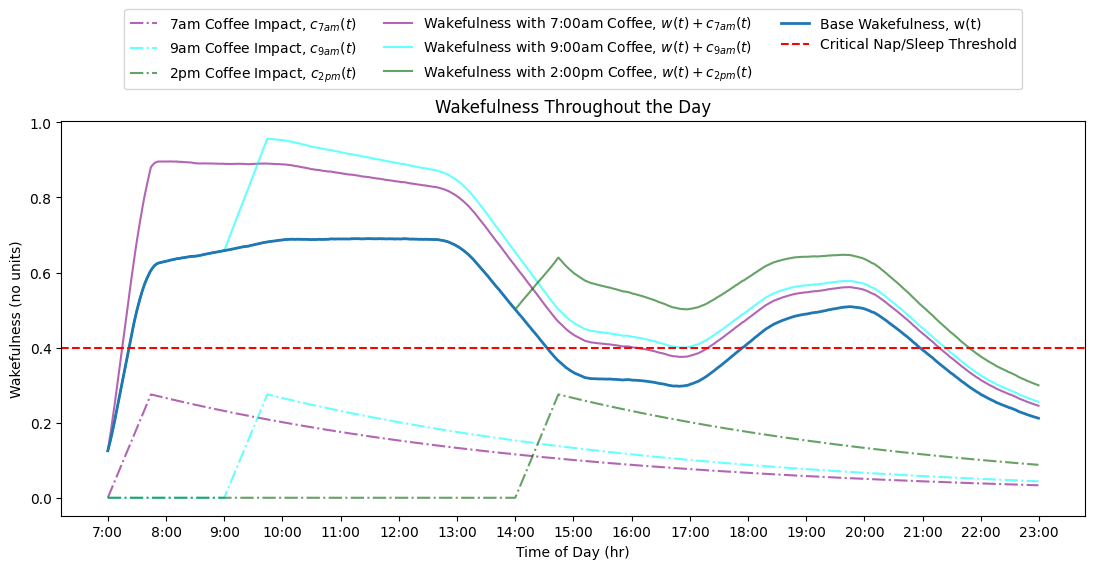

In [5]:
plt.figure(figsize=(13, 6))
nine_am_coffee = offset_coffee(200, coffee_wakefulness)
eleven_am_coffee = offset_coffee(400, coffee_wakefulness)
one_pm_coffee = offset_coffee(600, coffee_wakefulness)
two_pm_coffee = offset_coffee(700, coffee_wakefulness)
three_pm_coffee = offset_coffee(800, coffee_wakefulness)

plt.plot(x, coffee_wakefulness, label='7am Coffee Impact, $c_{7am}(t)$', linestyle='-.', color='purple', alpha=0.6)
plt.plot(x, nine_am_coffee, label='9am Coffee Impact, $c_{9am}(t)$', linestyle='-.', color='cyan', alpha=0.6)
# plt.plot(x, eleven_am_coffee, label='11am Coffee Impact, $c_{am}(t)$', linestyle='-.', color='orange')
# plt.plot(x, one_pm_coffee, label='1pm Coffee Impact', $c_{am}(t)$, linestyle='-.', color='lightgreen')
plt.plot(x, two_pm_coffee, label='2pm Coffee Impact, $c_{2pm}(t)$', linestyle='-.', color='darkgreen', alpha=0.6)
# plt.plot(x, three_pm_coffee, label='3pm Coffee Impact', $c_{7am}(t)$, linestyle='-.', color='yellow')

plt.plot(x, y_smooth + coffee_wakefulness, label='Wakefulness with 7:00am Coffee, $w(t) + c_{7am}(t)$', color='purple', alpha=0.6)
plt.plot(x, y_smooth + nine_am_coffee, label='Wakefulness with 9:00am Coffee, $w(t) + c_{9am}(t)$', color='cyan', alpha=0.6)
# plt.plot(x, y_smooth + eleven_am_coffee, label='Wakefulness with 11:00am Coffee', color='orange')
# plt.plot(x, y_smooth + one_pm_coffee, label='Wakefulness with 1:00pm Coffee', color='lightgreen')
plt.plot(x, y_smooth + two_pm_coffee, label='Wakefulness with 2:00pm Coffee, $w(t) + c_{2pm}(t)$', color='darkgreen', alpha=0.6)
# plt.plot(x, y_smooth + three_pm_coffee, label='Wakefulness with 3:00pm Coffee', color='yellow')

# Formatting ticks and labels as before
tick_positions = np.arange(0, 1601, 100)
tick_labels = [(7 + i) % 24 for i in range(0, len(tick_positions))]
tick_labels = [f'{label}:00' for label in tick_labels]
plt.xticks(tick_positions, tick_labels)

plt.plot(x, y_smooth, label='Base Wakefulness, w(t)', linewidth=2)
plt.axhline(y=0.4, color='red', linestyle='--', label='Critical Nap/Sleep Threshold')
plt.xlabel("Time of Day (hr)")
plt.ylabel("Wakefulness (no units)")
plt.title("Wakefulness Throughout the Day")

# Positioning the legend outside of the plot on the right
plt.legend(loc='upper center', bbox_to_anchor = (0.5,1.3) , ncols=3)

# Adjust the plot layout to make room for the legend
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the right margin
# plt.legend()
plt.show()

#Numerically calculating (estimating) the optimal caffeine intake time, $t_O$, using the optimization criteria above

In [6]:
def convert_to_time(value):
    # Constants
    start_hour = 7  # Start time is 7 AM
    hours_span = 16  # Span from 7 AM to 11 PM is 16 hours

    hours_added = int(value / 100)  # Each 100 units is an hour
    minutes_added = int((value % 100) * 0.6)  # Each unit is 0.6 minutes

    new_hour = start_hour + hours_added
    new_minute = minutes_added

    # Format time string in HH:MM format
    time_str = f"{new_hour:02d}:{new_minute:02d}"
    return time_str

In [8]:
A = 0.275  # Initial boost (adjustable)
half_life = 5  # Half-life of caffeine in hours
coffee_wakefulness = coffee_effect(x, A, half_life)

highest_min = -np.inf
highest_min_time = 0
highest_min_index = 0
lowest_min = np.inf
lowest_min_time = 0
lowest_min_index = 0

for i in range(len(x)):
    vect_to_min = y_smooth[50:1400] + offset_coffee(i, coffee_wakefulness)[50:1400] - 0.4
    new_min = np.min(vect_to_min)
    min_index = np.argmin(vect_to_min)  # get the index of the minimum value

    if new_min < lowest_min:
        lowest_min = new_min
        lowest_min_time = i
        lowest_min_index = min_index + 50  # account for the offset in slicing

    if new_min > highest_min:
        highest_min = new_min
        highest_min_time = i
        highest_min_index = min_index + 50  # account for the offset in slicing

print(f"Best time... Highest Minimum: {highest_min:.2f}, at coffee ingestion time i = {convert_to_time(highest_min_time)}, minimum occurring at {convert_to_time(highest_min_index)}")
print(f"Worst time... Lowest Minimum: {lowest_min:.2f}, at coffee ingestion time i = {convert_to_time(lowest_min_time)}, minimum occurring at {convert_to_time(lowest_min_index)}")

Best time... Highest Minimum: 0.10, at coffee ingestion time i = 13:54, minimum occurring at 07:30
Worst time... Lowest Minimum: -0.10, at coffee ingestion time i = 16:48, minimum occurring at 16:48
